### **Overview**

Throughout this assignment, you will be performing specific well-defined tasks that’ll strengthen your concepts in Explainable AI. We will be using the Breast Cancer Dataset and here is a brief context about the same:

Breast cancer is a type of cancer that starts in the breast. Cancer starts when cells begin to grow out of control. Breast cancer cells usually form a tumor that can often be seen on an x-ray or felt as a lump. Breast cancer occurs almost entirely in women, but men can get breast cancer, too.
A benign tumor is a tumor that does not invade its surrounding tissue or spread around the body. A malignant tumor is a tumor that may invade its surrounding tissue or spread around the body.

As part of the assignment, you will have to accomplish the below tasks.

**Author:** Ayoub Berdeddouch

###**Dataset**

Dataset Link: https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv

**About the dataset:**

Different features related to the breast are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe the characteristics of the cell nuclei present in the image.


* id: Id number
* agnosis: Cancer is Malignant or Benign (M = malignant, B = benign) - target variable

Other 20 features contain information about following 10 real valued features

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry  
* fractal dimension ("coastline approximation" - 1)

# Task 1

## Import Necessary Libraries

In [ ]:
!pip install shap
import shap as shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, r2_score, mean_squared_error

from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

     |████████████████████████████████| 564 kB 6.8 MB/s 


## Load the data
Display the first 5 rows of the data after loading.

In [ ]:
# import data
data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv')

# extract labels
labels = data["diagnosis"]

# drop labels and id from data
data.drop("diagnosis", inplace=True, axis=1)
data.drop("id", inplace=True, axis=1)


## Perform Basic Exploratory Data Analysis (EDA)

In [ ]:
data.loc[0,:]
data.shape
data.head(10)
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,14.070997,19.331985,91.589121,651.631910,0.096289,0.103197,0.087454,0.047821,0.181122,0.062800,...,16.202219,25.647286,106.882337,876.737186,0.132595,0.249983,0.269575,0.112627,0.288792,0.083445
std,3.577839,4.221225,24.706388,358.679197,0.012988,0.050805,0.079728,0.038329,0.026829,0.006794,...,4.898797,6.171891,34.370030,581.202196,0.022235,0.150280,0.210256,0.065617,0.058800,0.016469
min,6.981000,10.720000,43.790000,143.500000,0.052630,0.026500,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.870000,50.410000,185.200000,0.084840,0.043270,0.000000,0.000000,0.156500,0.055040
25%,11.645000,16.172500,74.690000,415.375000,0.086635,0.066013,0.028010,0.019787,0.161650,0.057717,...,12.980000,20.807500,83.730000,510.325000,0.116875,0.148600,0.116500,0.063532,0.250050,0.071240
50%,13.205000,18.895000,85.660000,538.300000,0.096515,0.095090,0.059935,0.033420,0.179300,0.061770,...,14.800000,25.225000,96.085000,671.500000,0.131600,0.211750,0.223050,0.100465,0.280650,0.080210
75%,15.745000,21.660000,103.700000,780.325000,0.105300,0.129550,0.126675,0.068282,0.195675,0.066188,...,18.540000,29.622500,125.075000,1048.500000,0.146375,0.330650,0.377400,0.157250,0.316875,0.091990
max,28.110000,33.810000,188.500000,2501.000000,0.132600,0.345400,0.426400,0.191300,0.290600,0.095750,...,36.040000,49.540000,251.200000,4254.000000,0.222600,0.937900,1.252000,0.291000,0.577400,0.148600


## Split the data into Train and Test Sets
The train to test ratio should be 80:20 and the random_state should be 0.

In [ ]:
# transform labels to 0-1
labels=np.array(labels)
for i in range(labels.shape[0]):
  if labels[i]=="M":
    labels[i] = 1
  else:
    labels[i] = 0
# count 
Counter(labels)

Counter({0: 250, 1: 148})

In [ ]:
# convert data to dummies
data = pd.get_dummies(data)


In [ ]:
# Split the data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

y_test=y_test.astype('int')
y_train=y_train.astype('int')

In [ ]:
X_train.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
3,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,0.06104,...,13.09,37.88,85.07,523.7,0.12080,0.18560,0.1811,0.07116,0.2447,0.08194
18,12.27,29.97,77.42,465.4,0.07699,0.03398,0.00000,0.00000,0.1701,0.05960,...,13.45,38.05,85.08,558.9,0.09422,0.05213,0.0000,0.00000,0.2409,0.06743
376,14.74,25.42,94.70,668.6,0.08275,0.07214,0.04105,0.03027,0.1840,0.05680,...,16.51,32.29,107.40,826.4,0.10600,0.13760,0.1611,0.10950,0.2722,0.06956


# Task 2

## Use Random Forest Machine Learning Model for prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, r2_score, mean_squared_error

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
y_pred





array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1])

## Evaluate the model using Accuracy Score

In [ ]:
confusion_matrix(y_test, y_pred, normalize='true')
confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred, normalize=True)

0.925

# Task 3: Explaining the model with SHAP and Lime.

##  Use a SHAP Explainer to derive SHAP Values for the random forest ml model.

In [ ]:
# creating an explainer for our model
explainer = shap.TreeExplainer(clf)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values[0]).head(5)


Expected Value: [0.63660377 0.36339623]


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.030601,-0.006605,-0.053176,-0.038655,-0.000830,-0.001994,-0.031624,-0.042320,-0.001067,-0.002809,...,-0.063883,-0.006930,-0.139537,-0.073715,0.000544,-0.005704,-0.015282,-0.047252,0.002429,-0.000592
1,0.021978,0.002558,0.030341,0.020566,-0.001165,0.002667,0.023344,0.028690,0.000328,0.001014,...,0.038450,0.006621,0.077604,0.041689,-0.004167,0.002386,0.013604,0.040949,0.002053,0.000848
2,-0.006271,-0.017723,-0.025292,0.000616,0.004571,-0.007252,-0.063689,-0.068478,-0.000847,-0.000015,...,-0.027466,-0.029848,-0.093928,-0.022063,-0.022057,-0.020151,-0.021447,-0.095849,-0.028134,-0.001134
3,-0.039347,-0.005034,-0.051108,-0.038932,-0.000681,-0.001198,-0.036727,-0.050510,-0.000399,-0.000816,...,-0.056022,-0.000922,-0.154355,-0.080738,-0.008274,0.001910,-0.014596,-0.047126,-0.000565,-0.000474
4,0.030754,0.004545,0.026253,0.027374,0.003002,-0.011229,-0.026433,-0.003542,-0.000067,0.001465,...,0.049576,0.021475,0.089463,0.058343,0.014797,-0.012104,-0.020570,0.010462,-0.000957,-0.000486


In [ ]:
pd.DataFrame(shap_values[1]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.030601,0.006605,0.053176,0.038655,0.000830,0.001994,0.031624,0.042320,0.001067,0.002809,...,0.063883,0.006930,0.139537,0.073715,-0.000544,0.005704,0.015282,0.047252,-0.002429,0.000592
1,-0.021978,-0.002558,-0.030341,-0.020566,0.001165,-0.002667,-0.023344,-0.028690,-0.000328,-0.001014,...,-0.038450,-0.006621,-0.077604,-0.041689,0.004167,-0.002386,-0.013604,-0.040949,-0.002053,-0.000848
2,0.006271,0.017723,0.025292,-0.000616,-0.004571,0.007252,0.063689,0.068478,0.000847,0.000015,...,0.027466,0.029848,0.093928,0.022063,0.022057,0.020151,0.021447,0.095849,0.028134,0.001134
3,0.039347,0.005034,0.051108,0.038932,0.000681,0.001198,0.036727,0.050510,0.000399,0.000816,...,0.056022,0.000922,0.154355,0.080738,0.008274,-0.001910,0.014596,0.047126,0.000565,0.000474
4,-0.030754,-0.004545,-0.026253,-0.027374,-0.003002,0.011229,0.026433,0.003542,0.000067,-0.001465,...,-0.049576,-0.021475,-0.089463,-0.058343,-0.014797,0.012104,0.020570,-0.010462,0.000957,0.000486


## Write your inferences from the generated plot.

This returns a matrix of SHAP values (# samples, # features). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value attribute of the explainer).

Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome. You'll see shap_values being used multiple times now.

Also, the Expected Value: 0.63660377 being displayed above will be used as the base value throughout all the visualizations below. The values above this base value will be put into class 1 (harmful cancer) wheras the values below it will be put into class 0 (harmless cancer).

# Task 4

## Plot a SHAP force plot for the first row of test data.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],shap_values[0][0],X_test.iloc[0,:])

## Write your inferences from the generated plot.

SHAP gives a nice reasoning above showing which features were the most influential in the model, taking the correct decision of predicting the person’s Cancer status to class B

The explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

We can see all the features are displayed in blue i.e all features contributed in making the income lower than the 50k dollars.

The final value(displayed in bold) is much lower than the base value. Thus, he is classified in the low income category.

# Task 5

## Plot a SHAP force plot for all the rows of the data

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],shap_values[0][0:],X_test.iloc[0:81,:])

## Write your inferences from the generated plot.

The above visualization can be interacted with in multiple ways. Try out the drop down boxes on both sides.

The default visualization(sample order by similarity i.e putting the people having the most similar features together) shows some interesting model prediction pattern decisions. You can hover over the graph to understand the following observations:

Most of the first 50 test samples probably have cancer class M and they have a perimeter_worst value of lower than 104.

Most of the next 30 test samples probably have cancer type B and they tend to have a perimeter_worst value bigger than 104

Definitely interesting how we can find out patterns which lead to the model making specific decisions and being able to provide explanations for them.

# Task 6

## Plot a SHAP summary plot using all the features in the data

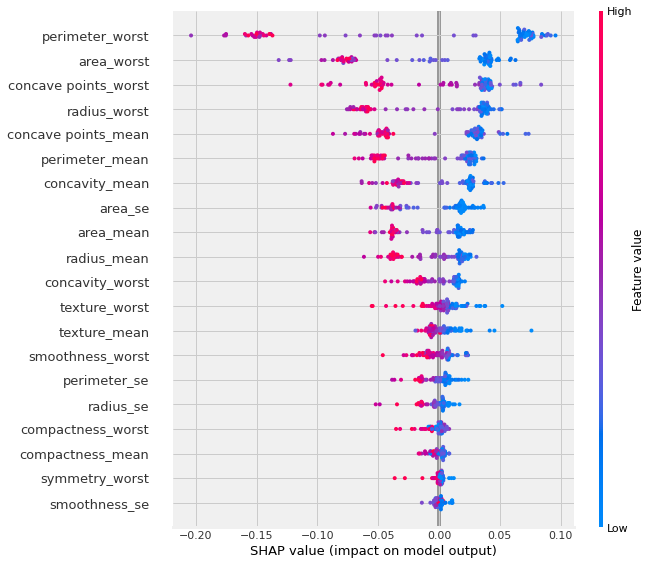

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[0],X_test)

This is the shap summary for all the features

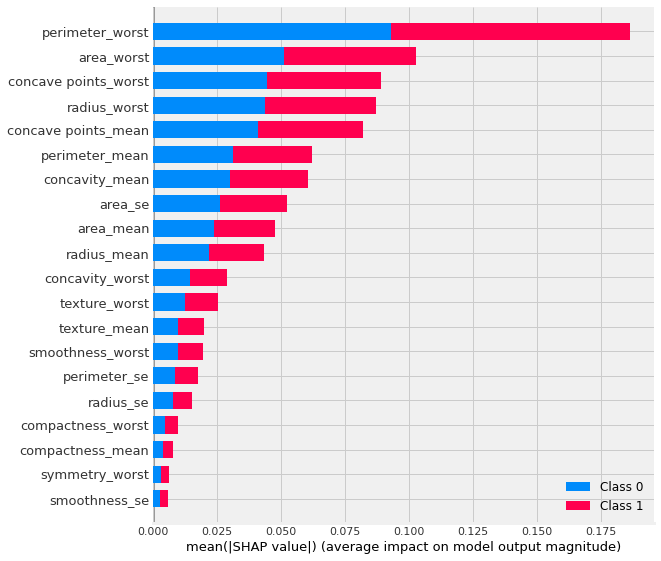

In [ ]:
shap.initjs()
shap.summary_plot(shap_values,X_test)

From the above simple bar chart, we observe that Parameter_worst and area_worst Features are the top 2 important features while determining the cancer class

On the other hand, symmetry_worst and smoothness_se are the least important features while determining the cancer type.

# Task 7

##Plot a SHAP dependecne plot using all features in the data

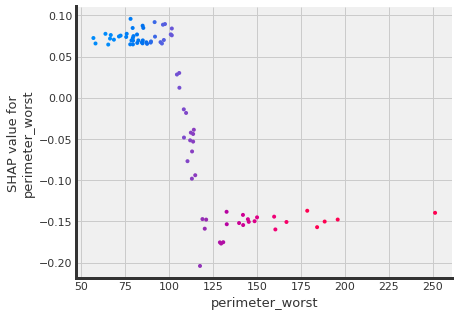

In [ ]:
shap.initjs()
shap.dependence_plot(ind="perimeter_worst",interaction_index="perimeter_worst",shap_values=shap_values[0],features=X_test)

Just like we observed during the model prediction explanations, people with low parameter_worst value have a higher shap value, pushing the model’s prediction decisions to say that these have cancer type M.

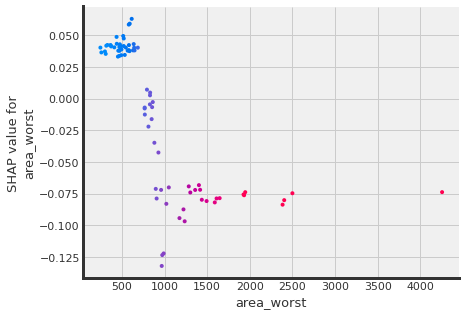

In [ ]:
shap.initjs()
shap.dependence_plot(ind="area_worst",interaction_index="area_worst",shap_values=shap_values[0],features=X_test)

Just like we observed during the model prediction explanations, people with low area_worst value have a higher shap value, pushing the model’s prediction decisions to say that these have cancer type M.

## Write your inferences from the generated plot.

# Task 8 (Optional)

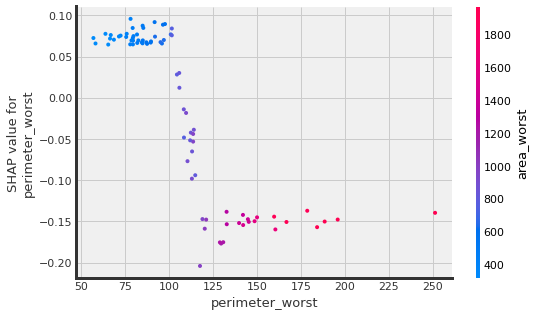

In [ ]:
shap.initjs()
shap.dependence_plot(ind="perimeter_worst",interaction_index="area_worst",shap_values=shap_values[0],features=X_test)

We see that perimeter_worst and area_worst are strongly positively correlated. And we see when area_worst or perimeter_worst have low value, then the shap value is going to be high, which yeals a cancer type class M.

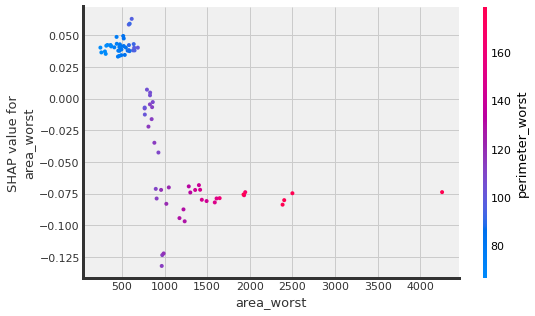

In [ ]:
shap.initjs()
shap.dependence_plot(ind="area_worst",interaction_index="perimeter_worst",shap_values=shap_values[0],features=X_test)

We see that perimeter_worst and area_worst are strongly positively correlated. And we see when area_worst or perimeter_worst have low value, then the shap value is going to be high, which yeals a cancer type class  M.

## Do anything and everything with SHAP
This is the section to explore what more you can do with SHAP. Create some meaningful visualisations and write down what you can infer from them. 

Who knows, this section might carry some bonus points.